### Imports

In [22]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

### Read data

In [23]:
# Relative path to the results folder
results_dir = '../results/'

# List all CSV files in the results directory
csv_files = [f for f in os.listdir(results_dir) if f.startswith('benchmark_results') and f.endswith('.csv')]

benchmark_data = {}

for csv_file in csv_files:
    # Extract matrix size from filename
    size = csv_file.split('_')[-1].split('.')[0]
    benchmark_data[size] = pd.read_csv(os.path.join(results_dir, csv_file))

### Times

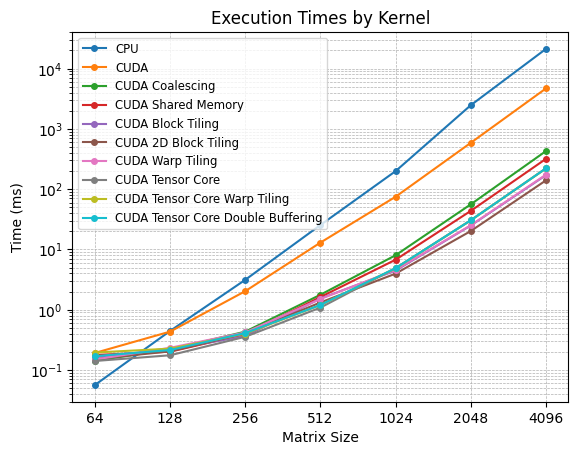

In [40]:
first_size = sorted(benchmark_data.keys(), key=int)[0]
kernels = benchmark_data[first_size]['Kernel'].tolist()

# Get sorted sizes
sizes = sorted(benchmark_data.keys(), key=int)

# Plot line graph for each kernel
for kernel in kernels:
    times = []
    for size in sizes:
        df = benchmark_data[size]
        # Get the time for this kernel, assuming one row per kernel per size, convert to ms
        time_val = df[df['Kernel'] == kernel]['Avg_Time(s)'].values[0] * 1000 if len(df[df['Kernel'] == kernel]) > 0 else None
        times.append(time_val)
    plt.plot(sizes, times, label=kernel.replace('GEMM ', ''), marker='o', markersize=4)

plt.xlabel('Matrix Size')
plt.ylabel('Time (ms)')
plt.title('Execution Times by Kernel')
plt.legend(fontsize='small')
plt.yscale('log', base=10)  # Set y-axis to log scale
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

### Speed-up

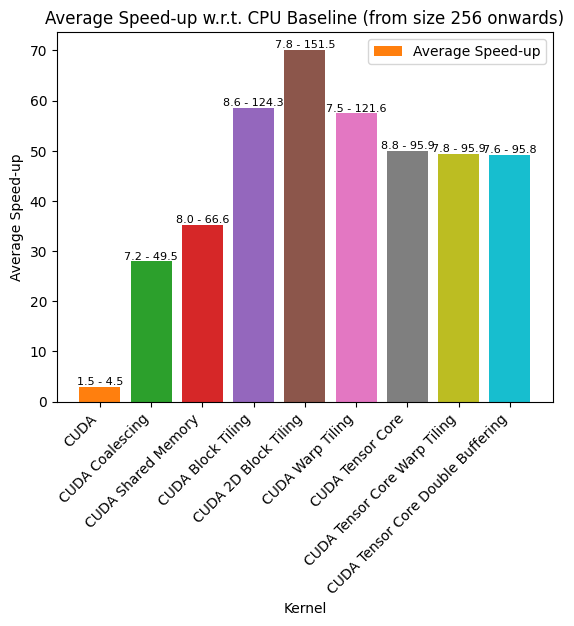

In [25]:
# Get kernels in the order they appear in the first CSV, excluding CPU
first_size = sorted(benchmark_data.keys(), key=int)[0]
kernels = benchmark_data[first_size]['Kernel'].tolist()
kernels = [k for k in kernels if k != 'GEMM CPU']

# Get sizes from 256 onwards
sizes = sorted([int(s) for s in benchmark_data.keys() if int(s) >= 256])

# Prepare data for bar chart
avgs = []
mins = []
maxs = []
for kernel in kernels:
    speed_ups = []
    for size in sizes:
        df = benchmark_data[str(size)]
        cpu_time = df[df['Kernel'] == 'GEMM CPU']['Avg_Time(s)'].values[0]
        kernel_time = df[df['Kernel'] == kernel]['Avg_Time(s)'].values[0]
        speed_up = cpu_time / kernel_time
        speed_ups.append(speed_up)
    avgs.append(np.mean(speed_ups))
    mins.append(np.min(speed_ups))
    maxs.append(np.max(speed_ups))

# Get the default color cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Plot bars for average speed-up with matching colors, skipping the first color (used by CPU)
x = np.arange(len(kernels))
bars = plt.bar(x, avgs, label='Average Speed-up', color=[colors[(i+1) % len(colors)] for i in range(len(kernels))])

# Add min and max on top of each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{mins[i]:.1f} - {maxs[i]:.1f}', ha='center', va='bottom', fontsize=8)

plt.xticks(x, [k.replace('GEMM ', '') for k in kernels], rotation=45, ha='right')
plt.xlabel('Kernel')
plt.ylabel('Average Speed-up')
plt.title('Average Speed-up w.r.t. CPU Baseline (from size 256 onwards)')
plt.legend()
plt.show()

### Correctness

In [26]:
# Get kernels in the order they appear in the first CSV
first_size = sorted(benchmark_data.keys(), key=int)[0]
kernels = benchmark_data[first_size]['Kernel'].tolist()

# Get sorted sizes
sizes = sorted(benchmark_data.keys(), key=int)

# Prepare data for correctness table
correctness_data = {}
for kernel in kernels:
    errors = []
    for size in sizes:
        df = benchmark_data[size]
        # Get the error for this kernel
        error_val = df[df['Kernel'] == kernel]['Avg_Error(%)'].values[0] if len(df[df['Kernel'] == kernel]) > 0 else None
        if error_val is not None:
            errors.append(error_val)
    # Calculate average error across sizes
    avg_error = sum(errors) / len(errors) if errors else None
    correctness_data[kernel.replace('GEMM ', '')] = avg_error

correctness_df = pd.DataFrame(list(correctness_data.items()), columns=['Kernel', 'Avg_Error(%)'])

# Display the table
correctness_df

,Kernel,Avg_Error(%)
0,CPU,0.000000
1,CUDA,0.000003
2,CUDA Coalescing,0.000003
3,CUDA Shared Memory,0.000003
4,CUDA Block Tiling,0.000003
5,CUDA 2D Block Tiling,0.000003
6,CUDA Warp Tiling,0.000003
7,CUDA Tensor Core,0.002770
8,CUDA Tensor Core Warp Tiling,0.002770
9,CUDA Tensor Core Double Buffering,0.002770
